In [465]:
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions

In [466]:
path = kagglehub.dataset_download("shriyashjagtap/e-commerce-customer-for-behavior-analysis")

print("Path to dataset files:", path)

Path to dataset files: /Users/gulsumasenacakir/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4


In [467]:
files = os.listdir(path)
print("Files in the dataset:")
for file_name in files:
    print(file_name)

Files in the dataset:
ecommerce_customer_data_large.csv
ecommerce_customer_data_custom_ratios.csv


In [468]:
data = pd.read_csv('/Users/gulsumasenacakir/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4/ecommerce_customer_data_large.csv')
data.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [469]:
data.shape

(250000, 13)

In [470]:
def data_quality(data):
    missing = data.isnull().sum()
    unique_val = data.nunique()
    datatypes = data.dtypes
    check = pd.DataFrame({
        'missing': missing,
        'unique value': unique_val,
        'datatypes': datatypes
    })
    return check

In [471]:
data_check = data_quality(data)
data_check

,missing,unique value,datatypes
Customer ID,0,49661,int64
Purchase Date,0,249728,object
Product Category,0,4,object
Product Price,0,491,int64
Quantity,0,5,int64
Total Purchase Amount,0,5245,int64
Payment Method,0,3,object
Customer Age,0,53,int64
Returns,47382,2,float64
Customer Name,0,39878,object


In [472]:
if data['Customer Age'].equals(data['Age']):
    print('they are identical')
else:
    print('they are not identical')

they are identical


In [473]:
data = data.drop('Customer Age', axis = 1)

In [474]:
null_percentage = data['Returns'].isnull().sum()/len(data)
null_percentage

0.189528

In [475]:
df = data.dropna()

In [476]:
df = df.sort_values('Customer ID', ascending=True)

In [477]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Customer Name,Age,Gender,Churn
160921,1,2021-04-08 18:33:34,Books,456,5,5148,Credit Card,0.0,Dominic Cline,67,Female,0
225933,2,2023-07-03 17:26:19,Books,190,1,4693,Credit Card,1.0,Crystal Day,42,Female,0
225937,2,2023-04-26 10:10:00,Electronics,461,5,604,Cash,0.0,Crystal Day,42,Female,0
225936,2,2022-09-04 02:27:42,Electronics,227,4,1002,PayPal,1.0,Crystal Day,42,Female,0
225935,2,2022-03-14 04:31:25,Home,376,4,4726,Cash,1.0,Crystal Day,42,Female,0


Customer Name will be removed

In [478]:
df = df.drop('Customer Name', axis=1)

purchase date column

In [479]:
df[['Purchase Date']].dtypes

Purchase Date    object
dtype: object

In [480]:
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df['date'] = df['Purchase Date'].dt.date.astype(str)
df['hour'] = df['Purchase Date'].dt.hour
df['year_month'] = df['Purchase Date'].dt.strftime('%Y-%m')

In [481]:
df['date'].min(), df['date'].max()

('2020-01-01', '2023-09-13')

In [482]:
df = df.drop('Purchase Date', axis = 1)

In [483]:
df.dtypes

Customer ID                int64
Product Category          object
Product Price              int64
Quantity                   int64
Total Purchase Amount      int64
Payment Method            object
Returns                  float64
Age                        int64
Gender                    object
Churn                      int64
date                      object
hour                       int32
year_month                object
dtype: object

### 1) EDA

#### Purchase Amount

In [484]:
avg_purchase_over_time = df.groupby(df['year_month'])['Total Purchase Amount'].mean()

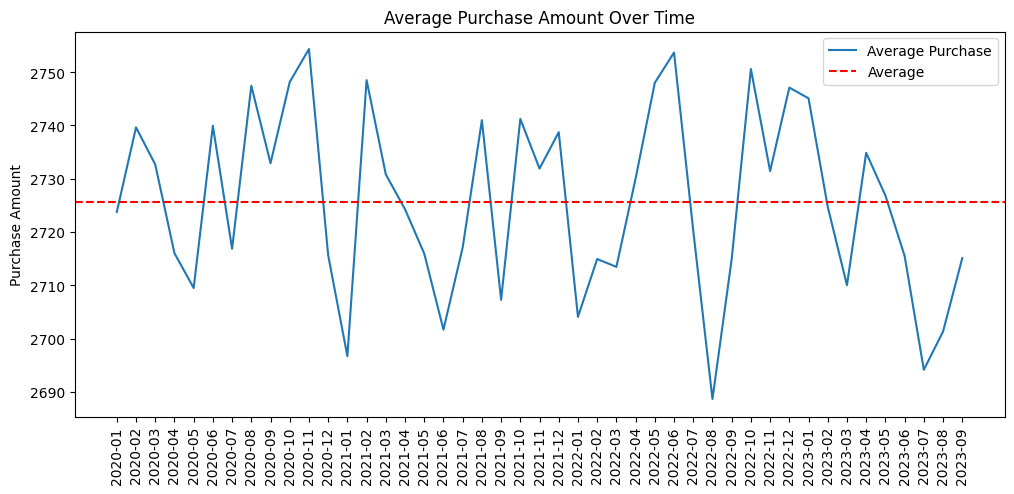

In [485]:
plt.figure(figsize=(12, 5))
plt.plot(avg_purchase_over_time.index, avg_purchase_over_time.values, label='Average Purchase')
plt.axhline(y=np.mean(avg_purchase_over_time.values), color='red', linestyle='--', label='Average') 
plt.title('Average Purchase Amount Over Time')
plt.xlabel('')
plt.ylabel('Purchase Amount')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [486]:
avg_purchase_time = df.groupby('hour')['Total Purchase Amount'].mean()

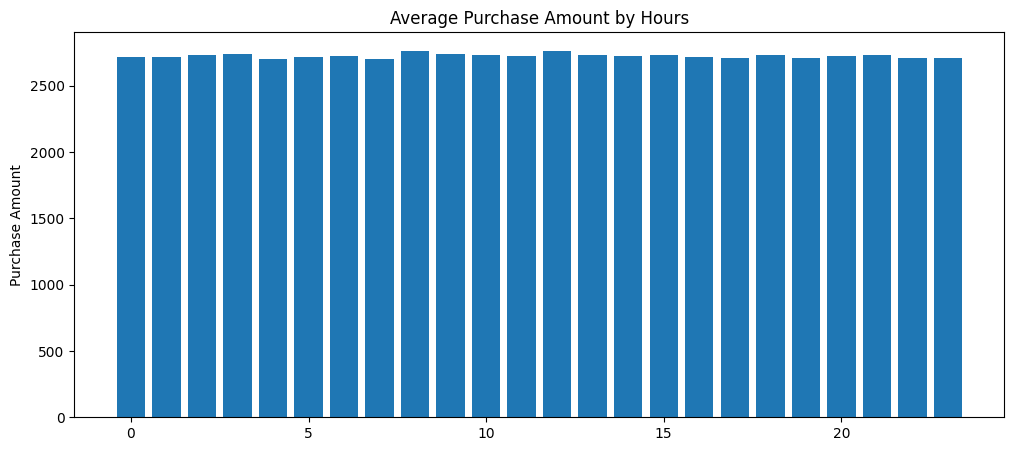

In [487]:
plt.figure(figsize=(12,5))
plt.bar(avg_purchase_time.index, avg_purchase_time.values)
plt.title('Average Purchase Amount by Hours')
plt.xlabel('')
plt.ylabel('Purchase Amount')
plt.show()

#### Returns

In [488]:
returns = df.groupby('year_month')['Returns'].mean()

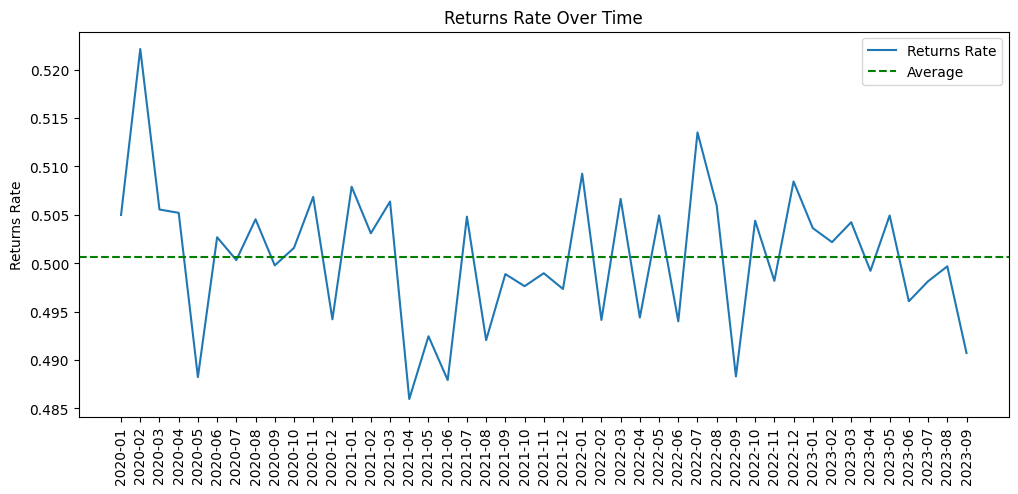

In [489]:
plt.figure(figsize=(12, 5))
plt.plot(returns.index, returns.values, label='Returns Rate')
plt.axhline(y=np.mean(returns.values), color='green', linestyle='--', label='Average')  # Ortalama çizgisini ekle
plt.title('Returns Rate Over Time')
plt.xlabel('')
plt.ylabel('Returns Rate')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [490]:
returns_by_products = df.groupby('Product Category')['Returns'].mean()

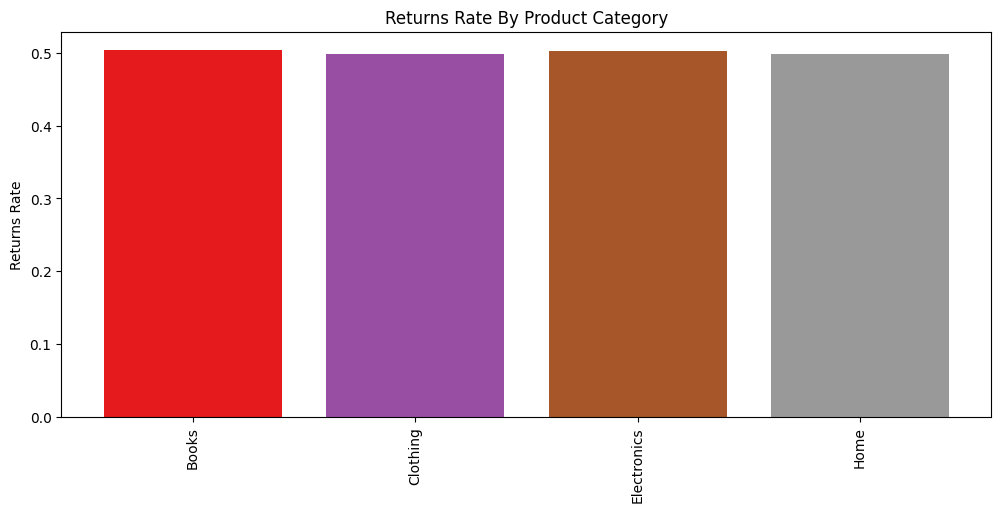

In [491]:
colors = plt.cm.Set1(np.linspace(0, 1, len(returns_by_products.index)))
plt.figure(figsize=(12,5))
plt.bar(returns_by_products.index, returns_by_products.values, color=colors)
plt.title('Returns Rate By Product Category')
plt.xlabel('')
plt.ylabel('Returns Rate')
plt.xticks(rotation=90) 
plt.show()

Most customers have made multiple purchases. To accurately capture churn status, I retained only the rows corresponding to each customer’s latest purchase.

#### Churn Rate

In [492]:
# for example
df[(df['Customer ID'] == 2) | (df['Customer ID'] == 7)][['Customer ID', 'date', 'Churn']]

,Customer ID,date,Churn
225933,2,2023-07-03,0
225937,2,2023-04-26,0
225936,2,2022-09-04,0
225935,2,2022-03-14,0
225932,2,2020-07-31,0
225934,2,2021-08-30,0
28034,7,2022-11-24,1
28032,7,2021-09-21,1
28031,7,2020-04-02,1
28028,7,2022-12-25,1


In [493]:
latest_purchase = df.sort_values('date').drop_duplicates('Customer ID', keep='last').sort_values('Customer ID')
latest_purchase.shape

(49146, 13)

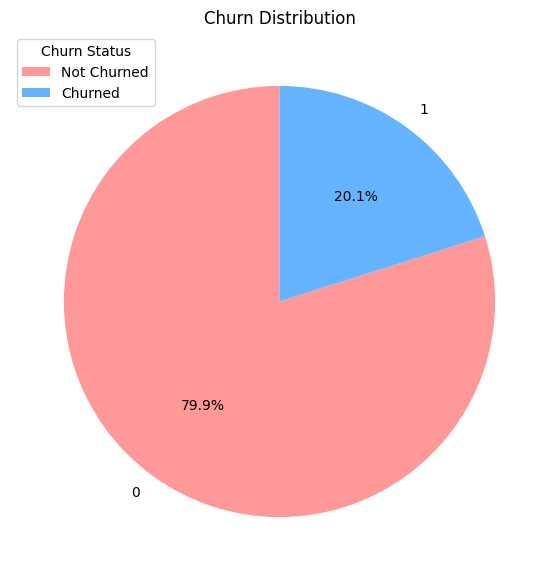

In [494]:
churn_rate = df['Churn'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(churn_rate, labels=churn_rate.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Churn Distribution')
plt.legend(['Not Churned', 'Churned'], title="Churn Status")
plt.show()

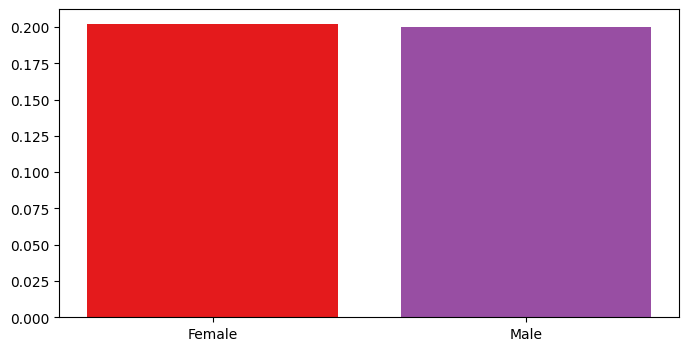

In [495]:
churnrate_by_gender = df.groupby('Gender')['Churn'].mean()
plt.figure(figsize=(8,4))
plt.bar(churnrate_by_gender.index, churnrate_by_gender.values, color = colors)
plt.show()

### 2) Survival Analysis

#### Data Prep

First, I calculate the tenure of each customer.

In [496]:
customer_tenure = df.groupby('Customer ID')['date'].agg(['min', 'max']).reset_index()
customer_tenure['min'] = pd.to_datetime(customer_tenure['min'])
customer_tenure['max'] = pd.to_datetime(customer_tenure['max'])
#customer_tenure['tenure'] = (customer_tenure['max'] - customer_tenure['min']).dt.days
def calculate_months(row):
    delta = relativedelta(row['max'], row['min'])
    return delta.years * 12 + delta.months

customer_tenure['tenure'] = customer_tenure.apply(calculate_months, axis=1)
customer_tenure = customer_tenure.drop(['min', 'max'], axis=1)
customer_tenure

,Customer ID,tenure
0,1,0
1,2,35
2,3,0
3,4,20
4,5,21
...,...,...
49141,49996,24
49142,49997,12
49143,49998,39
49144,49999,25


If tenure is 0, the customer made purchase once.

In [497]:
(customer_tenure[customer_tenure['tenure'] == 0]).shape

(3746, 2)

There are 3,428 customers who have made only one purchase.

In [498]:
customer_info = df.groupby('Customer ID')[['Age', 'Gender', 'Churn']].first().reset_index()
customer_info = customer_info.merge(customer_tenure, how='left', on = 'Customer ID')
customer_info['Gender'] = customer_info['Gender'].replace({'Male':0, 'Female':1})
customer_info

,Customer ID,Age,Gender,Churn,tenure
0,1,67,1,0,0
1,2,42,1,0,35
2,3,31,0,0,0
3,4,37,0,0,20
4,5,24,1,0,21
...,...,...,...,...,...
49141,49996,45,1,0,24
49142,49997,65,0,0,12
49143,49998,31,1,1,39
49144,49999,70,1,0,25


In [499]:
purchase_return = df.groupby('Customer ID').agg({'Total Purchase Amount': 'sum', 'Returns':'mean'}).reset_index()
customer_info = customer_info.merge(purchase_return, how = 'left', on = 'Customer ID')
category_quantity = df.groupby(['Customer ID', 'Product Category'])['Quantity'].sum().unstack(fill_value=0).reset_index()
category_quantity.columns = [col if col == 'Customer ID' else f"{col}_quant" for col in category_quantity.columns]
customer_info = customer_info.merge(category_quantity, how = 'left', on = 'Customer ID')
customer_info

,Customer ID,Age,Gender,Churn,tenure,Total Purchase Amount,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant
0,1,67,1,0,0,5148,0.000000,5,0,0,0
1,2,42,1,0,35,16481,0.666667,1,2,11,4
2,3,31,0,0,0,4687,0.000000,0,0,3,0
3,4,37,0,0,20,7826,0.600000,8,5,3,3
4,5,24,1,0,21,7681,1.000000,5,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
49141,49996,45,1,0,24,21762,0.333333,13,0,0,7
49142,49997,65,0,0,12,5714,0.000000,0,4,4,0
49143,49998,31,1,1,39,20495,0.600000,18,5,7,0
49144,49999,70,1,0,25,12709,0.600000,9,3,1,2


In [500]:
df['total_price'] = df['Product Price'] * df['Quantity']
total_price = df.groupby('Customer ID')['total_price'].sum().reset_index()
customer_info = customer_info.merge(total_price, how = 'left', on = 'Customer ID')
customer_info

,Customer ID,Age,Gender,Churn,tenure,Total Purchase Amount,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant,total_price
0,1,67,1,0,0,5148,0.000000,5,0,0,0,2280
1,2,42,1,0,35,16481,0.666667,1,2,11,4,6459
2,3,31,0,0,0,4687,0.000000,0,0,3,0,564
3,4,37,0,0,20,7826,0.600000,8,5,3,3,4339
4,5,24,1,0,21,7681,1.000000,5,0,0,3,1230
...,...,...,...,...,...,...,...,...,...,...,...,...
49141,49996,45,1,0,24,21762,0.333333,13,0,0,7,5872
49142,49997,65,0,0,12,5714,0.000000,0,4,4,0,1592
49143,49998,31,1,1,39,20495,0.600000,18,5,7,0,8440
49144,49999,70,1,0,25,12709,0.600000,9,3,1,2,2408


In [501]:
df_grouped = df.groupby(['Customer ID'])['Payment Method'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()
df_grouped = df_grouped.rename(columns={'Payment Method': 'Payment_Method'})
customer_info = customer_info.merge(df_grouped, how = 'left', on='Customer ID')

In [502]:
df_survival = customer_info.drop('Customer ID', axis = 1)

In [503]:
df_survival = df_survival.rename(columns={'Total Purchase Amount': 'total_purchase'})
df_survival['total_purchase'] = np.log1p(df_survival['total_purchase'])
df_survival['age_group'] = pd.qcut(df_survival['Age'], q=3, labels=['18-39', '40-54', '55-70'])
df_survival

,Age,Gender,Churn,tenure,total_purchase,Returns,Books_quant,Clothing_quant,Electronics_quant,Home_quant,total_price,Payment_Method,age_group
0,67,1,0,0,8.546558,0.000000,5,0,0,0,2280,Credit Card,55-70
1,42,1,0,35,9.710024,0.666667,1,2,11,4,6459,"Cash, Credit Card, PayPal",40-54
2,31,0,0,0,8.452761,0.000000,0,0,3,0,564,Cash,18-39
3,37,0,0,20,8.965335,0.600000,8,5,3,3,4339,"Cash, Credit Card, PayPal",40-54
4,24,1,0,21,8.946635,1.000000,5,0,0,3,1230,"Cash, Credit Card, PayPal",18-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49141,45,1,0,24,9.987967,0.333333,13,0,0,7,5872,"Cash, PayPal",40-54
49142,65,0,0,12,8.650850,0.000000,0,4,4,0,1592,"Cash, PayPal",55-70
49143,31,1,1,39,9.927985,0.600000,18,5,7,0,8440,"Cash, Credit Card, PayPal",18-39
49144,70,1,0,25,9.450144,0.600000,9,3,1,2,2408,"Cash, Credit Card, PayPal",55-70


In [504]:
df_survival.columns

Index(['Age', 'Gender', 'Churn', 'tenure', 'total_purchase', 'Returns',
       'Books_quant', 'Clothing_quant', 'Electronics_quant', 'Home_quant',
       'total_price', 'Payment_Method', 'age_group'],
      dtype='object')

#### Survival Analysis

##### Kaplan-Meier

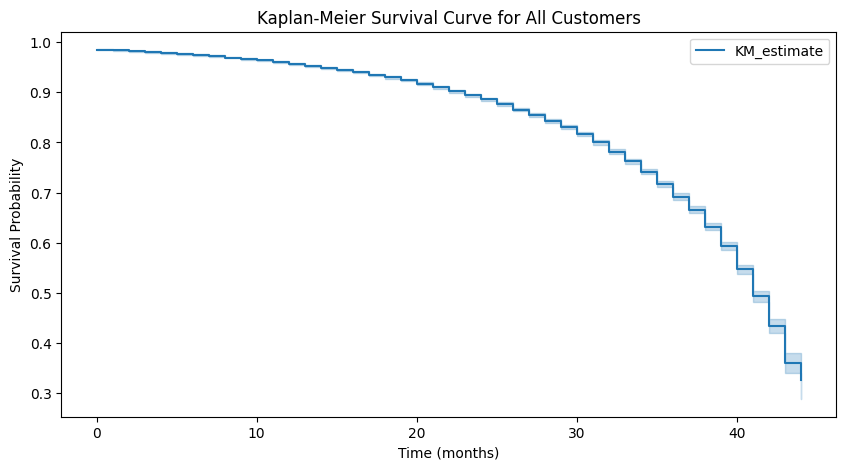

In [505]:
kmf = KaplanMeierFitter()
kmf.fit(df_survival['tenure'], event_observed=df_survival['Churn'])
plt.figure(figsize=(10,5))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve for All Customers')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.show()

In [506]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.985085
1.0,0.983697
2.0,0.982255
3.0,0.980451
4.0,0.978656
5.0,0.976333
6.0,0.974395
7.0,0.972145
8.0,0.969227


In [507]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,3746,733,3013,49146,49146
1.0,354,64,290,0,45400
2.0,398,66,332,0,45046
3.0,414,82,332,0,44648
4.0,415,81,334,0,44234
5.0,490,104,386,0,43819
6.0,467,86,381,0,43329
7.0,551,99,452,0,42862
8.0,626,127,499,0,42311


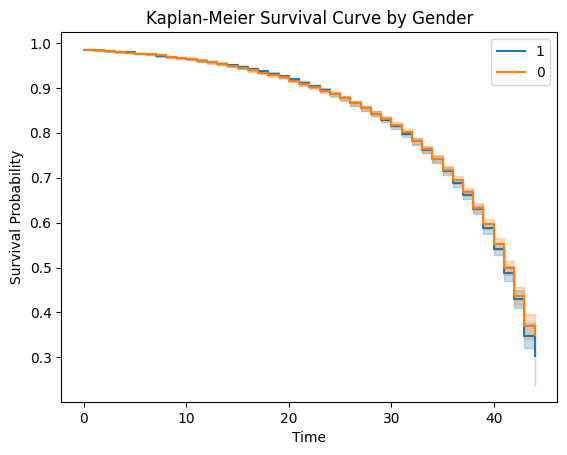

In [508]:
for gender in df_survival['Gender'].unique():
    mask = df_survival['Gender'] == gender
    kmf.fit(df_survival[mask]['tenure'], event_observed=df_survival[mask]['Churn'], label=str(gender))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Gender')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

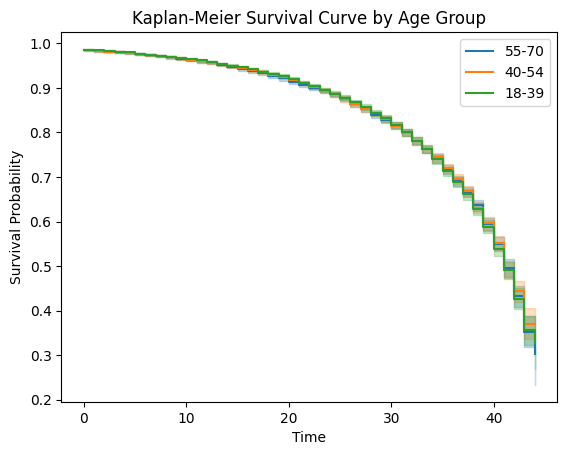

In [509]:
for age in df_survival['age_group'].unique():
    mask = df_survival['age_group'] == age
    kmf.fit(df_survival[mask]['tenure'], event_observed=df_survival[mask]['Churn'], label=str(age))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Age Group')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

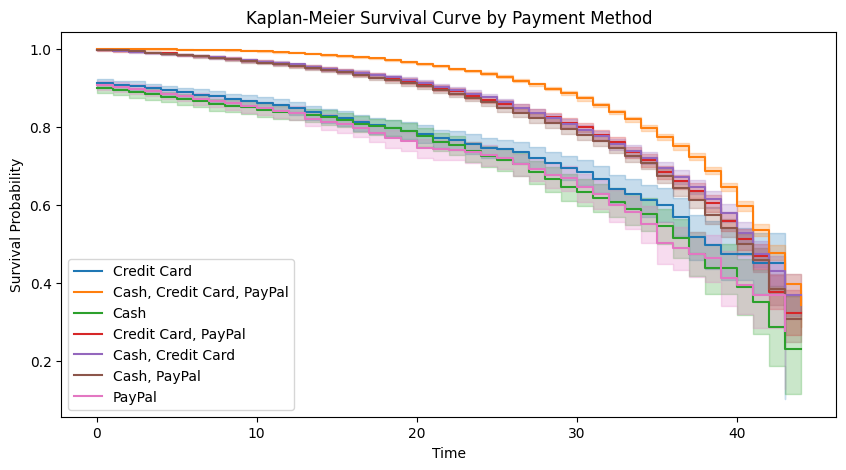

In [510]:
plt.figure(figsize=(10,5))
for payment in df_survival['Payment_Method'].unique():
    mask = df_survival['Payment_Method'] == payment
    kmf.fit(df_survival[mask]['tenure'], event_observed=df_survival[mask]['Churn'], label=str(payment))
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by Payment Method')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

##### Cox’s proportional hazard model

In [511]:
df_survival = df_survival.drop(['age_group', 'Payment_Method'], axis =1)

In [512]:
cox_model = CoxPHFitter(penalizer=1.0)
cox_model.fit(df_survival, duration_col='tenure', event_col='Churn')

<lifelines.CoxPHFitter: fitted with 49146 total observations, 39328 right-censored observations>

In [513]:
cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 49146 total observations, 39328 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
                penalizer = 1.0
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 49146
number of events observed = 9818
   partial log-likelihood = -96330.80
         time fit was run = 2024-11-09 18:41:42 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Age                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Gender             0.00      1.00      0.01           -0.01            0.02                0.99                1.02
total_purchase    -0.09      0.91      0.01           -0.10           -0.08                0.90                0.92
Returns           -0.01      0.99      0.01           -0.04            0.02                0.96                1.02
Books_quant       -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
Clothing_quant    -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
Electronics_quant -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
Home_quant        -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
total_price       -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                   cmp to      z      p  -log2(p)
covariate                                        
Age                  0.00   0.07   0.94      0.08
Gender               0.00   0.32   0.75      0.42
total_purchase       0.00 -14.41 <0.005    154.05
Returns              0.00  -0.78   0.43      1.20
Books_quant          0.00  -7.12 <0.005     39.74
Clothing_quant       0.00  -7.12 <0.005     39.74
Electronics_quant    0.00  -7.54 <0.005     44.27
Home_quant           0.00  -7.23 <0.005     40.95
total_price          0.00 -11.53 <0.005     99.73
---
Concordance = 0.70
Partial AIC = 192679.60
log-likelihood ratio test = 649.76 on 9 df
-log2(p) of ll-ratio test = 443.03

<Axes: xlabel='log(HR) (95% CI)'>

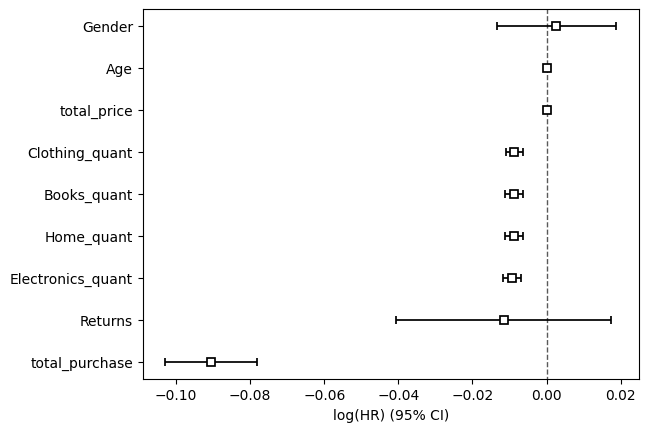

In [514]:
cox_model.plot()

In [515]:
cox_model.hazard_ratios_

covariate
Age                  1.000019
Gender               1.002674
total_purchase       0.913411
Returns              0.988480
Books_quant          0.991287
Clothing_quant       0.991369
Electronics_quant    0.990789
Home_quant           0.991197
total_price          0.999975
Name: exp(coef), dtype: float64

In [516]:
cox_model.predict_median(df_survival)

0        40.0
1        42.0
2        40.0
3        41.0
4        40.0
         ... 
49141    42.0
49142    40.0
49143    43.0
49144    41.0
49145    42.0
Name: 0.5, Length: 49146, dtype: float64

#### Customer LTV

First, I need to prepare RFM (Recency, Frequency, Monetary) dataset.

**Recency**: The age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. 

**Frequency**: The count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

**Monetary Value**: This is equal to the sum of all a customer’s purchases divided by the total number of purchases. 

**T**: The duration between a customer’s first purchase and the end of the period under study.

In [517]:
df_cltv = df[['Customer ID', 'Product Price', 'Quantity', 'date']].reset_index()
df_cltv = df_cltv.rename(columns={'Customer ID': 'id', 'Product Price': 'price', 'Quantity': 'quant'})
df_cltv['total_purchase'] = df_cltv['quant'] * df_cltv['price']
df_cltv

,index,id,price,quant,date,total_purchase
0,160921,1,456,5,2021-04-08,2280
1,225933,2,190,1,2023-07-03,190
2,225937,2,461,5,2023-04-26,2305
3,225936,2,227,4,2022-09-04,908
4,225935,2,376,4,2022-03-14,1504
...,...,...,...,...,...,...
202613,23862,50000,107,3,2020-10-04,321
202614,23866,50000,308,1,2020-03-11,308
202615,23864,50000,406,1,2023-05-14,406
202616,23860,50000,409,2,2020-01-17,818


In [518]:
df_cltv['date'] = pd.to_datetime(df_cltv['date'])
snapshot_date = df_cltv['date'].max() + pd.Timedelta(days=2)
snapshot_date

Timestamp('2023-09-15 00:00:00')

In [519]:
df_cltv_last = df_cltv.groupby('id').agg(
    T=('date', lambda x: (snapshot_date - x.min()).days),
    recency = ('date', lambda x: (x.max() - x.min()).days),
    frequency=('date', 'count'),
    monetary=('total_purchase', 'mean')
).reset_index()
df_cltv_last

,id,T,recency,frequency,monetary
0,1,890,0,1,2280.000000
1,2,1141,1067,6,1076.500000
2,3,224,0,1,564.000000
3,4,1068,625,5,867.800000
4,5,1179,640,3,410.000000
...,...,...,...,...,...
49141,49996,1105,744,6,978.666667
49142,49997,785,395,2,796.000000
49143,49998,1232,1217,10,844.000000
49144,49999,1149,791,5,481.600000


##### BG/NBD model

In [520]:
bgf = BetaGeoFitter(penalizer_coef=0.0001)  
bgf.fit(df_cltv_last['frequency'], df_cltv_last['recency'], df_cltv_last['T'])

<lifetimes.BetaGeoFitter: fitted with 49146 subjects, a: 0.53, alpha: 3199.32, b: 7.22, r: 14.77>

In [521]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,14.768844,0.181013,14.414058,15.123629
alpha,3199.323664,41.009369,3118.945301,3279.702027
a,0.529321,0.016486,0.497009,0.561633
b,7.217762,0.197340,6.830975,7.604548


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

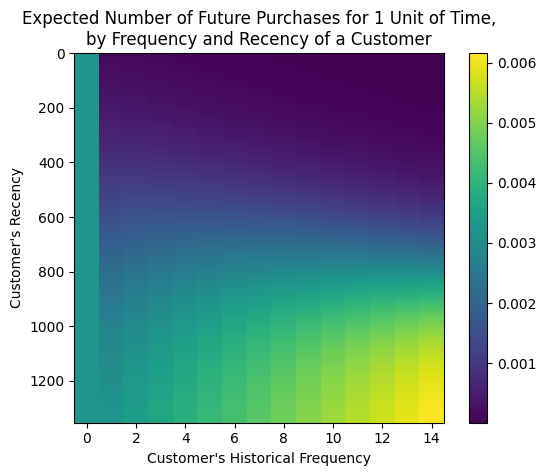

In [522]:
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

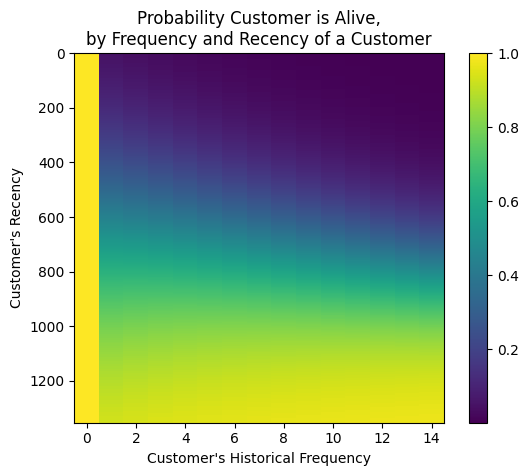

In [523]:
plot_probability_alive_matrix(bgf)

In [524]:
t = 365
df_cltv_last['expected_purc_1_year'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_cltv_last['frequency'], df_cltv_last['recency'], df_cltv_last['T'])
df_cltv_last.sort_values(by='expected_purc_1_year').tail(5)

,id,T,recency,frequency,monetary,expected_purc_1_year
32581,33138,997,993,12,723.500000,2.191981
5412,5498,622,607,10,825.100000,2.205226
13578,13805,1223,1196,14,694.714286,2.237376
25987,26422,973,887,13,602.076923,2.245416
44334,45098,872,780,14,691.500000,2.379953


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

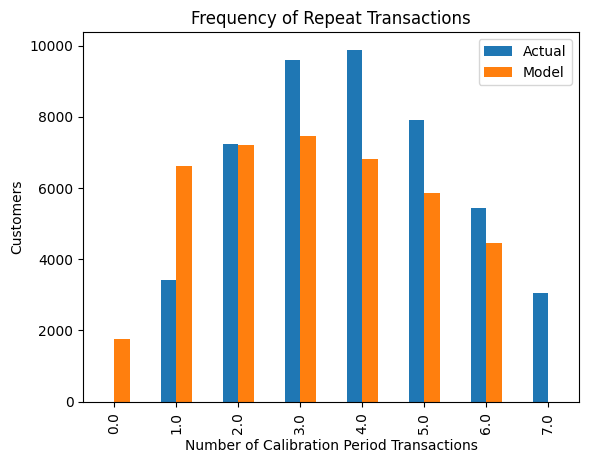

In [525]:
plot_period_transactions(bgf)

After predicting the expected number of purchases of each customer. We need to use monetary value in order to predict CLTV.

##### Gamma-Gamma model

In [526]:
df_cltv_last[['frequency','monetary']].corr()

,frequency,monetary
frequency,1.000000,0.003222
monetary,0.003222,1.000000


The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. The correlation displayed above is very close to 0. So, I can use the gamma-gamma model.

In [527]:
ggf = GammaGammaFitter(penalizer_coef = 0.0001)
ggf.fit(df_cltv_last['frequency'],
        df_cltv_last['monetary'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 49146 subjects, p: 31.44, q: 1.97, v: 32.94>


In [528]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        df_cltv_last['frequency'],
        df_cltv_last['monetary']
    ).mean(),
    df_cltv_last[df_cltv_last['frequency']>0]['monetary'].mean()
))

Expected conditional average profit: 769.8867303944623, Average profit: 766.940925513261


CLTV:

In [529]:
cltv = ggf.customer_lifetime_value(
    bgf,  
    df_cltv_last['frequency'],
    df_cltv_last['recency'],
    df_cltv_last['T'],
    df_cltv_last['monetary'],
    time=365, # one year  
    discount_rate=0.00035  # Daily discount rate
)

df_cltv_last = df_cltv_last[['id']].copy()
df_cltv_last['CLTV'] = cltv

df_cltv_sorted = df_cltv_last.sort_values(by='CLTV', ascending=False)

print(df_cltv_sorted.head(10))


          id          CLTV
11817  12017  55158.364586
12309  12517  54833.086818
16829  17113  53880.774639
11172  11357  51777.804646
48427  49269  51581.951110
28621  29103  50699.151209
27184  27639  50549.440722
18092  18387  50002.236687
28433  28914  49948.142550
39909  40598  49947.513564
